# Emotion Classifier

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation, Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from math import ceil

## 0. Setup

In [2]:
train = True
width = 48
height = 48
export = False
model_name = ''

## 1. Data Preparation

In [3]:
data = pd.read_csv('../../data/emotion/fer2013.csv')
labels = pd.read_csv('../../data/emotion/fer2013new.csv')

classes = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 
           'disgust', 'fear', 'contempt', 'unknown', 'NF']

n_samples = len(data)
y = np.array(labels[classes])
X = np.zeros((n_samples, width, height, 1))
for i in range(n_samples):
    X[i] = np.fromstring(data['pixels'][i], dtype=int, sep=' ').reshape((height, width, 1))

In [4]:
# Remove unknown or NF images
y_mask = y.argmax(axis=-1)
mask = y_mask < classes.index('unknown')
X = X[mask]
y = y[mask]
y = y[:, :-2] * 0.1

# Add contempt to neutral
y[:, 0] += y[:, 7]
y = y[:, :7]

# Normalize images
X /= 255

In [5]:
test_size = ceil(len(X) * 0.1)

# Split Data
x_train, x_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=test_size, 
                                                    random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                  y_train, 
                                                  test_size=test_size, 
                                                  random_state=42)

In [6]:
shift = 0.1
datagen = ImageDataGenerator(rotation_range=20,
                             horizontal_flip=True,
                             height_shift_range=shift,
                             width_shift_range=shift)

datagen.fit(x_train)

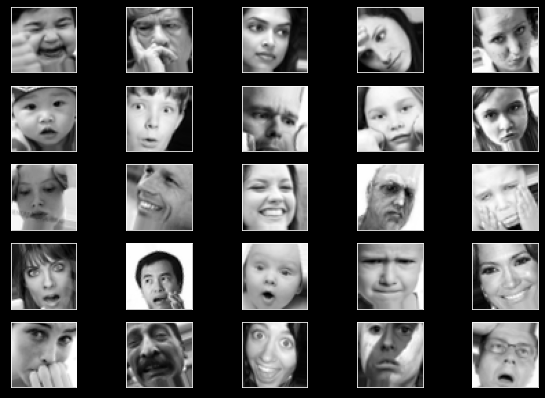

In [7]:
it = datagen.flow(x_train, y_train, batch_size=1)
plt.figure(figsize=(10, 7))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(it.next()[0][0], cmap='gray')

plt.show()

## 2. Model Training

In [8]:
epochs = 100
batch_size = 64

print("X_train shape: " + str(x_train.shape))
print("Y_train shape: " + str(y_train.shape))
print("X_test shape: " + str(x_test.shape))
print("Y_test shape: " + str(y_test.shape))
print("X_val shape: " + str(x_val.shape))
print("Y_val shape: " + str(y_val.shape))

X_train shape: (28390, 48, 48, 1)
Y_train shape: (28390, 7)
X_test shape: (3549, 48, 48, 1)
Y_test shape: (3549, 7)
X_val shape: (3549, 48, 48, 1)
Y_val shape: (3549, 7)


In [9]:
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=(width, height, 1)))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Dropout(0.5))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(256, (3, 3)))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Conv2D(256, (3, 3)))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))

model.summary()
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 46, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 44, 44, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 44, 44, 64)        0

In [10]:
train_progress = None

if train:
    early_stopping = EarlyStopping(patience=10,
                                   verbose=2,
                                   restore_best_weights=True)
    
    train_progress = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), 
                               epochs=epochs, 
                               steps_per_epoch=len(x_train) // batch_size, 
                               validation_data=(x_val, y_val), 
                               verbose=2,
                               callbacks=[early_stopping])
    
    test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=batch_size)

Epoch 1/100
443/443 - 48s - loss: 0.3454 - accuracy: 0.4128 - val_loss: 0.3681 - val_accuracy: 0.3824 - 48s/epoch - 109ms/step
Epoch 2/100
443/443 - 42s - loss: 0.3087 - accuracy: 0.5331 - val_loss: 0.2995 - val_accuracy: 0.5785 - 42s/epoch - 96ms/step
Epoch 3/100
443/443 - 43s - loss: 0.2839 - accuracy: 0.5949 - val_loss: 0.2715 - val_accuracy: 0.6438 - 43s/epoch - 97ms/step
Epoch 4/100
443/443 - 41s - loss: 0.2669 - accuracy: 0.6350 - val_loss: 0.2499 - val_accuracy: 0.6805 - 41s/epoch - 93ms/step
Epoch 5/100
443/443 - 41s - loss: 0.2558 - accuracy: 0.6599 - val_loss: 0.2435 - val_accuracy: 0.6754 - 41s/epoch - 94ms/step
Epoch 6/100
443/443 - 42s - loss: 0.2467 - accuracy: 0.6810 - val_loss: 0.2352 - val_accuracy: 0.7205 - 42s/epoch - 94ms/step
Epoch 7/100
443/443 - 41s - loss: 0.2409 - accuracy: 0.6968 - val_loss: 0.2405 - val_accuracy: 0.7050 - 41s/epoch - 92ms/step
Epoch 8/100
443/443 - 41s - loss: 0.2360 - accuracy: 0.7096 - val_loss: 0.2421 - val_accuracy: 0.6844 - 41s/epoch - 9

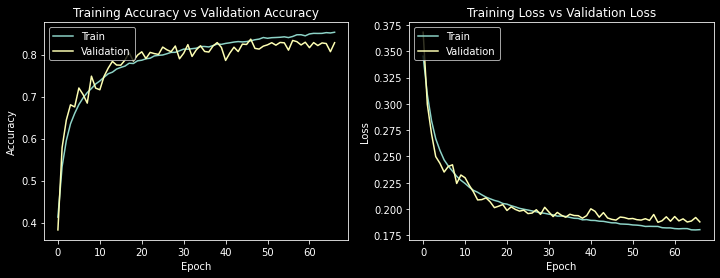

In [11]:
if train_progress:
    fig, ax = plt.subplots(1, 2)
    train_acc = train_progress.history['accuracy']
    train_loss = train_progress.history['loss']
    fig.set_size_inches(12, 4)

    ax[0].plot(train_progress.history['accuracy'])
    ax[0].plot(train_progress.history['val_accuracy'])
    ax[0].set_title('Training Accuracy vs Validation Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='upper left')

    ax[1].plot(train_progress.history['loss'])
    ax[1].plot(train_progress.history['val_loss'])
    ax[1].set_title('Training Loss vs Validation Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='upper left')

    plt.show()

In [12]:
if export:
    model.save(f'../models/{model_name}.h5')